# Cluster count-only SACC file creation

This notebook examplifies the creation of a SACC file for cluster count, using pre-extracted halo catalog from the SkySim dataset. It
- shows how to load the data
- counts halos in the richness and redshift plane
- computes the covariance using jackknife resampling (to be eventually done by TJPCov)
- **save the count and covariance in the SACC format**

In [1]:
%load_ext autoreload
%autoreload 2
#!/usr/bin/env python

try:
    import gi

    gi.require_version("NumCosmo", "1.0")
    gi.require_version("NumCosmoMath", "1.0")
except:
    pass

import math
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm
import sys

sys.path.insert(0, "../../scripts")
import os
import numpy as np
from astropy.table import Table
from numpy import random
import scipy
import matplotlib.pyplot as plt
import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData
from clmm import Cosmology
from clmm.support import mock_data as mock
import pandas as pd
import numpy as np
import pyccl as ccl
import sacc

clmm.__version__
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import scipy.integrate
import astropy.units as u


Ncm.cfg_init()
Ncm.cfg_set_log_handler(lambda msg: sys.stdout.write(msg) and sys.stdout.flush())

%matplotlib inline
catalog = "skysim5000_v1.1.1"
sys.path.insert(0, "/pbs/home/e/ebarroso/gcr-catalogs")
import GCRCatalogs

GCRCatalogs.set_root_dir_by_site("in2p3")
skysim_cat = GCRCatalogs.load_catalog(catalog)
cosmo_ss = skysim_cat.cosmology

In [2]:
sacc.__version__

'0.8.1'

# Generating data with NumCosmo

## Creating NumCosmo Mass function and Number Counts Object

In [3]:
print(cosmo_ss.H0, cosmo_ss.Om0)

71.0 km / (Mpc s) 0.2648


In [4]:
cosmo = Nc.HICosmoDEXcdm()
reion = Nc.HIReionCamb.new()
prim = Nc.HIPrimPowerLaw.new()

cosmo.add_submodel(reion)
cosmo.add_submodel(prim)

dist = Nc.Distance.new(2.0)

tf = Nc.TransferFunc.new_from_name("NcTransferFuncEH")

psml = Nc.PowspecMLTransfer.new(tf)

# psml = Nc.PowspecMLCBE.new ()
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()


cosmo.props.H0 = cosmo_ss.H0.value
cosmo.props.Omegab = cosmo_ss.Ob0
cosmo.props.Omegac = cosmo_ss.Odm0
cosmo.props.Omegax = cosmo_ss.Ode0

cosmo.omega_x2omega_k()
cosmo.param_set_by_name("Omegak", 0.0)

prim.props.n_SA = cosmo_ss.n_s
print(cosmo_ss.sigma8, cosmo.sigma8(psf), cosmo.Omega_k0())

old_amplitude = math.exp(prim.props.ln10e10ASA)
prim.props.ln10e10ASA = math.log(
    (cosmo_ss.sigma8 / cosmo.sigma8(psf)) ** 2 * old_amplitude
)
print(cosmo_ss.sigma8, cosmo.sigma8(psf))
print(
    cosmo_ss.H0.value,
    cosmo_ss.Ob0,
    cosmo_ss.Odm0,
    cosmo_ss.Ode,
    cosmo_ss.n_s,
    cosmo_ss.Neff,
)

0.8 0.8490796381176396 0.0
0.8 0.7999999999999999
71.0 0.0448 0.21999999999999997 <bound method FLRW.Ode of FlatLambdaCDM(H0=71.0 km / (Mpc s), Om0=0.2648, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=0.0448)> 0.963 3.04


In [5]:
# CosmoSim_proxy model
# M_0, z_0
theta_pivot = [3e14 / 0.71, 0.6]


area = 439.78986
lnRl = 0.0
lnRu = 5.0
zl = 0.2
zu = 0.65

# Numcosmo_proxy model based on arxiv 1904.07524v2
cluster_z = Nc.ClusterRedshift.new_from_name(
    "NcClusterRedshiftNodist{'z-min': <%20.15e>, 'z-max':<%20.15e>}" % (zl, zu)
)

cluster_m = Nc.ClusterMass.new_from_name(
    "NcClusterMassAscaso{'M0':<%20.15e>,'z0':<%20.15e>,'lnRichness-min':<%20.15e>, 'lnRichness-max':<%20.15e>}"
    % (3e14 / (0.71), 0.6, lnRl, lnRu)
)
cluster_m.param_set_by_name("mup0", 3.19)
cluster_m.param_set_by_name("mup1", 2 / np.log(10))
cluster_m.param_set_by_name("mup2", -0.7 / np.log(10))
cluster_m.param_set_by_name("sigmap0", 0.33)
cluster_m.param_set_by_name("sigmap1", -0.08 / np.log(10))
cluster_m.param_set_by_name("sigmap2", 0 / np.log(10))

In [6]:
# Numcosmo Mass Function

# First we need to define the multiplicity function here we will use the tinker
mulf = Nc.MultiplicityFuncTinker.new()
mulf.set_linear_interp(True)
mulf.set_mdef(Nc.MultiplicityFuncMassDef.MEAN)
mulf.set_Delta(200)
# Second we need to construct a filtered power spectrum

hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hmf.set_area_sd(area)

# Cluster Abundance Obj
ca = Nc.ClusterAbundance.new(hmf, None)

In [7]:
# Number Counts object
ncount = Nc.DataClusterNCount.new(ca, "NcClusterRedshiftNodist", "NcClusterMassAscaso")

ca.prepare(cosmo, cluster_z, cluster_m)
mset = Ncm.MSet.new_array([cosmo, cluster_z, cluster_m])

rng = Ncm.RNG.seeded_new(None, 42)

ncount.init_from_sampling(mset, area * ((np.pi / 180) ** 2), rng)


In [8]:
ncount.catalog_save("ncount_rich_3.fits", True)
ncount.catalog_load("ncount_rich_3.fits")

ncdata_fits = fits.open("ncount_rich_3.fits")
# ncdata_fits.info()

ncdata_data = ncdata_fits[1].data

ncdata_Table = Table(ncdata_data)
ncdata_Table.columns
# ncdata_Table.sort('LNM_TRUE')

display(ncdata_Table)

Z_OBS,LNM_OBS,Z_TRUE,LNM_TRUE
float64,float64,float64,float64
0.2608325447342572,2.5684083760968037,0.2608325447342572,32.54368600618273
0.5299337311988379,0.46882215548028905,0.5299337311988379,30.538321337799154
0.2281374509371929,1.3551404652700865,0.2281374509371929,30.246435489987633
0.4515143199401622,0.06096176533487095,0.4515143199401622,30.062952073141858
0.6424729887525561,0.13254829125809042,0.6424729887525561,30.297306871521325
0.2886819071709008,0.6097498207336214,0.2886819071709008,31.219522066453077
0.4443659722776738,0.5146747684110289,0.4443659722776738,30.537258022408164
0.47783830215453965,0.1383181225180969,0.47783830215453965,29.97445599199998
0.21692673263144327,2.545081910318195,0.21692673263144327,32.25706108612661


## Plot of Cluster Mass versus Richness

     LNM_TRUE     
------------------
 32.54368600618273
30.538321337799154
30.246435489987633
30.062952073141858
30.297306871521325
31.219522066453077
30.537258022408164
 29.97445599199998
 32.25706108612661
30.243354117767687
               ...
30.450780528770135
30.258312550884764
 31.16068755473424
 30.56397694271294
30.626064843702245
 30.81886053423664
30.207265432060638
31.458356079697868
31.308693383581417
 30.25848547849567
30.669383840695886
Length = 72078 rows


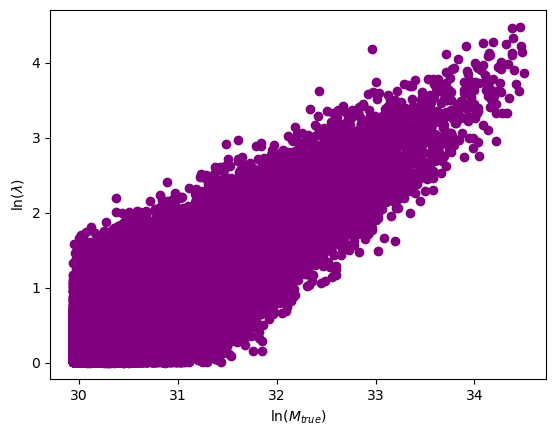

In [9]:
plt.xlabel("$\ln(M_{true})$")
plt.ylabel("$\ln(\lambda)$")
plt.savefig("richscatter", bbox_inches="tight")
np.exp(32)
# ncdata_Table = ncdata_Table[ncdata_Table['LNM_OBS'] > np.log(5) ]
# ncdata_Table = ncdata_Table[ncdata_Table['LNM_TRUE'] > 32 ]
print(ncdata_Table["LNM_TRUE"])
plt.scatter(
    np.array(ncdata_Table["LNM_TRUE"]),
    np.array(ncdata_Table["LNM_OBS"]),
    color="purple",
)

(array([7671., 7831., 7840., 7372., 6809., 6034., 5149., 4314., 3765.,
        3081., 2563., 2064., 1610., 1303., 1101.,  826.,  704.,  505.,
         385.,  337.,  242.,  178.,  114.,   94.,   57.,   43.,   37.,
          23.,   14.,   12.]),
 array([13.00000605, 13.06608863, 13.13217121, 13.19825379, 13.26433636,
        13.33041894, 13.39650152, 13.4625841 , 13.52866667, 13.59474925,
        13.66083183, 13.7269144 , 13.79299698, 13.85907956, 13.92516214,
        13.99124471, 14.05732729, 14.12340987, 14.18949245, 14.25557502,
        14.3216576 , 14.38774018, 14.45382275, 14.51990533, 14.58598791,
        14.65207049, 14.71815306, 14.78423564, 14.85031822, 14.9164008 ,
        14.98248337]),
 <BarContainer object of 30 artists>)

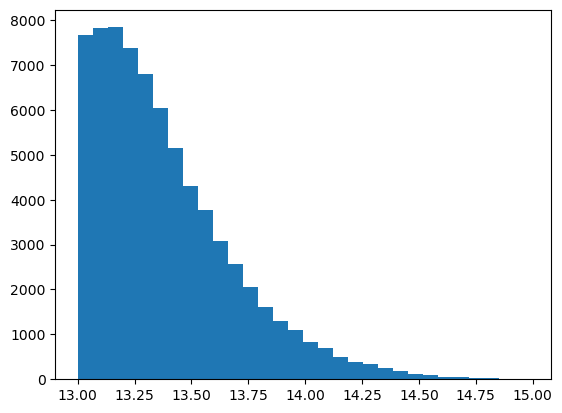

In [10]:
plt.hist(np.log10(np.exp(ncdata_Table["LNM_TRUE"])), bins=30)

In [11]:
data_table = ncdata_Table
cluster_z = data_table["Z_OBS"]
cluster_lnm = data_table["LNM_OBS"]
cluster_z = np.array(cluster_z)
cluster_richness = np.log10(np.exp(np.array(cluster_lnm)))

## Count halos in the $N_{\rm richness} \times N_z$ richness-redshift planecosmo_ss

[5.64434040e-06 3.89113926e-01 7.78222208e-01 1.16733049e+00
 1.55643877e+00 1.94554705e+00]


2.302585092994046

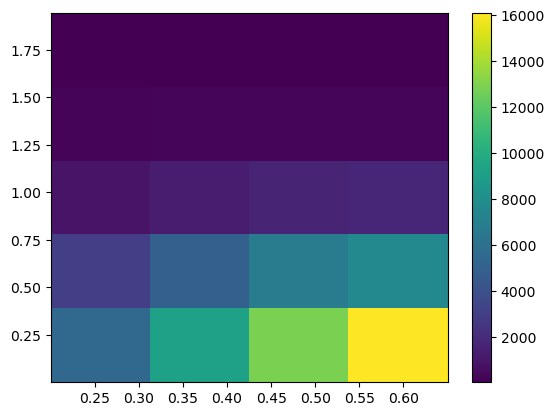

In [12]:
N_richness = 5  # number of richness bins
N_z = 4  # number of redshift bins

data_lz, z_edges, richness_edges, im = plt.hist2d(
    cluster_z, (cluster_richness), bins=[N_z, N_richness]
)
print(richness_edges)
#print(z_edges)
#print(data_lz)
fig = plt.colorbar()
plt.savefig("bins")
np.log(10)

## Covariance

Here we are using a jackknife resampling method to compute the count covariance from the data (adapted from C. Payerne's [code](https://github.com/LSSTDESC/CLCosmo_Sim/blob/issue/15/binned_cosmological_analysis/cluster_abundance/CL_COUNT_DATAOPS_cluster_abundance_covariance.py) in the CLCosmoSim repo). Eventually, this will be replaced by the theoretical covariance provided by `TJPCov`.

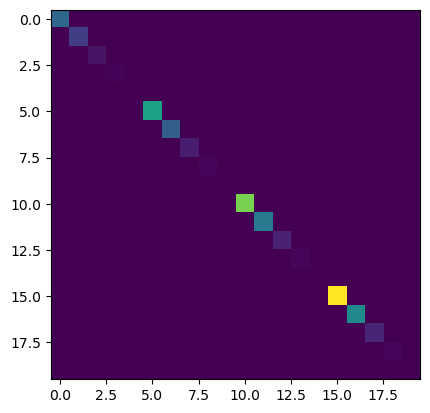

In [13]:
covariance = np.zeros((N_richness * N_z, N_richness * N_z))
np.fill_diagonal(covariance, (data_lz.flatten()))
plt.imshow((covariance))

**Correlation matrix - the "large blocks" correspond to the $N_z$ redshift bins. In each redshift bin are the $N_{\rm richness}$ richness bins.**

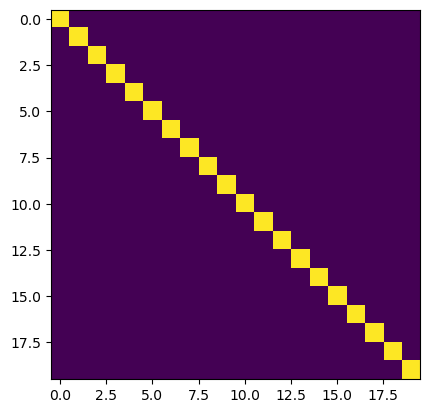

In [14]:
plt.imshow(np.corrcoef(covariance))
# plt.imshow((covariance))

## Store everything in a SACC file

In [15]:
from firecrown.sacc_support import sacc
import itertools
s_count = sacc.Sacc()
bin_z_labels = []
bin_richness_labels = []

survey_name = "NC_mock_redshift_mass"
s_count.add_tracer("cluster_survey", survey_name, area)

for i, z_bin in enumerate(zip(z_edges[:-1], z_edges[1:])):
    lower, upper = z_bin
    print(z_bin)
    bin_z_label = f"bin_z_{i}"
    s_count.add_tracer("bin_z", bin_z_label, lower, upper)
    bin_z_labels.append(bin_z_label)

for i, richness_bin in enumerate(zip(richness_edges[:-1], richness_edges[1:])):
    lower, upper = richness_bin
    print(richness_bin)
    bin_richness_label = f"bin_rich_{i}"
    s_count.add_tracer(
        "bin_richness", bin_richness_label, lower, upper
    )
    print(lower,upper)
    bin_richness_labels.append(bin_richness_label)

cluster_count = sacc.standard_types.cluster_counts
cluster_mass = sacc.standard_types.cluster_mean_log_mass

counts_and_edges = zip(
    data_lz.flatten(), itertools.product(bin_z_labels, bin_richness_labels)
)

for counts, (bin_z_label, bin_richness_label) in counts_and_edges:
    s_count.add_data_point(
        cluster_count, (survey_name, bin_z_label, bin_richness_label), int(counts)
    )

# Then the add the covariance and save the file
s_count.add_covariance(covariance)
s_count.to_canonical_order()
s_count.save_fits("cluster_redshift_richness_sacc_data.fits", overwrite=True)

(0.2000149359332703, 0.31250999365698834)
(0.31250999365698834, 0.4250050513807063)
(0.4250050513807063, 0.5375001091044244)
(0.5375001091044244, 0.6499951668281424)
(5.644340396171686e-06, 0.38911392625546615)
5.644340396171686e-06 0.38911392625546615
(0.38911392625546615, 0.7782222081705361)
0.38911392625546615 0.7782222081705361
(0.7782222081705361, 1.167330490085606)
0.7782222081705361 1.167330490085606
(1.167330490085606, 1.556438772000676)
1.167330490085606 1.556438772000676
(1.556438772000676, 1.945547053915746)
1.556438772000676 1.945547053915746


In [16]:
s_count.data

[DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_mass', 'bin_z_0', 'bin_rich_0'), value=5371, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_mass', 'bin_z_0', 'bin_rich_1'), value=2969, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_mass', 'bin_z_0', 'bin_rich_2'), value=855, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_mass', 'bin_z_0', 'bin_rich_3'), value=170, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_mass', 'bin_z_0', 'bin_rich_4'), value=16, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_mass', 'bin_z_1', 'bin_rich_0'), value=9183, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_mass', 'bin_z_1', 'bin_rich_1'), value=4874, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_mass', 'bin_z_1', 'bin_rich_2'), value=1284, ),
 DataPoint(data_type='cluster_counts', tracers=('NC_mock_redshift_mass', 'bin_z_1', 'bin_ric